# Explore Scratchpad
This notebook is where I am working through my messy exploration stage of the zillow data and testing modules developed so far.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from env import host, user, password
import evaluate
import prepare
import acquire
import os
from math import sqrt
import math

from scipy import stats

import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

from statsmodels.formula.api import ols

# Handle large numbers w/o using scientific notation
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Acquire the data
df = acquire.get_zillow_data()
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,latitude,longitude,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,propertylandusetypeid,propertylandusedesc
0,11721753,2.000,3.000,2.000,1316.000,6037.000,34033180.000,-118355396.000,41948.000,205123.000,163175.000,2627.480,261.000,Single Family Residential
1,11289917,2.000,3.000,2.000,1458.000,6037.000,34686163.000,-118113100.000,108890.000,136104.000,27214.000,2319.900,261.000,Single Family Residential
2,11705026,1.000,2.000,1.000,1421.000,6037.000,33999877.000,-118291863.000,11982.000,35606.000,23624.000,543.690,261.000,Single Family Residential
3,14269464,3.000,4.000,3.000,2541.000,6059.000,33694636.000,-117912245.000,434887.000,880456.000,445569.000,9819.720,261.000,Single Family Residential
4,11446756,2.000,3.000,2.000,1491.000,6037.000,33873860.000,-118338253.000,60537.000,107110.000,46573.000,1399.270,261.000,Single Family Residential


In [ ]:
#def get_county(df):
#    county = []
#
#    for row in df['fips']:
#        if row == 6037:
#            county.append('Los Angeles')
#        elif row == 6059:
#            county.append('Orange')
#        elif row == 6111:
#            county.append('Ventura')
#        
#    df['county'] = county
#    return df

In [ ]:
#df = get_county(df)

In [ ]:
df.shape

In [ ]:
df.fips.value_counts()

In [ ]:
df.info()

In [ ]:
#def get_tax_rate(df):
#    calc_tax_rate = df.taxamount/df.taxvaluedollarcnt
#    tax_rate = []
#    df['tax_rate'] = tax_rate
#    for x in df['tax_rate']:
#        x = calc_tax_rate
#        tax_rate.append(x)
#    
#    return df

#def calculate_tax_rate(df):
#    calc_tax_rate = (df.taxamount/df.taxvaluedollarcnt)
#    return df.assign(tax_rate=calc_tax_rate)
#

In [ ]:
#df = calculate_tax_rate(df)
#df.head()

In [ ]:
df.propertylandusedesc.unique()

In [ ]:

def get_latitude(df):
    '''
    This function takes in a datafame with latitude formatted as a float,
    converts it to a int and utilizes lambda to return the latitude values
    in a correct format.
    '''
    df.latitude = df.latitude.astype(int)
    df['latitude'] = df['latitude'].apply(lambda x: x / 10 ** (len((str(x))) - 2))
    return df

def get_longitude(df):
    '''This function takes in a datafame with longitude formatted as a float,
    converts it to a int and utilizes lambda to return the longitude values
    in the correct format.
    '''
    df.longitude = df.longitude.astype(int)
    df['longitude'] = df['longitude'].apply(lambda x: x / 10 ** (len((str(x))) - 4))
    return df

def get_county(df):
    county = []

    for row in df['fips']:
        if row == 6037:
            county.append('Los Angeles')
        elif row == 6059:
            county.append('Orange')
        elif row == 6111:
            county.append('Ventura')
        
        df['county'] = county
    return df

def calculate_tax_rate(df):
    calc_tax_rate = (df.taxamount/df.taxvaluedollarcnt)
    return df.assign(tax_rate=calc_tax_rate)

def bathrooms_per_squareft(df):
    calc_bath_per_sqft = (df.bathroomcnt/df.calculatedfinishedsquarefeet)
    return df.assign(bath_per_sqft=calc_bath_per_sqft)

In [ ]:
def clean_zillow(df):
    '''
    This function reads in the zillow dataframe with 15 columns and 24950 rows
    from my acquire module and cleans it by: 

        - Setting index to parcelid
        - Replace missing values that could be calculated from other fields:
            -calculatedbathnbr
            -structuretaxdollarvaluecnt
        -Formatting latitude and longitude columns correctly
        -Droping remaining observations with missing values.

    It returns a dataframe with 14 columns and 24947 rows.
    '''
    # Set parcelid as the index
    df = df.set_index('parcelid')
    
    #Replace missing values in calculatedbathnbr with corresponding batrhoomcnt
    df.calculatedbathnbr = df.calculatedbathnbr.fillna(df.bathroomcnt)
    
    #Replace missing values in structuretaxvaluedollarcount = taxvaluedollarcnt - landtaxvaluedollarcnt
    df.structuretaxvaluedollarcnt.fillna((df.taxvaluedollarcnt - df.landtaxvaluedollarcnt), inplace=True)

    #Drop observations with missing values
    df.dropna(inplace=True)

    #Call calculate_tax_rate function to calculate tax rates
    df = calculate_tax_rate(df)

    #Call bathrooms_per_squarefeet function to calculate the rate of ba per sqft
    df = bathrooms_per_squareft(df)
    
    return df

In [ ]:
df = clean_zillow(df)

In [ ]:
df.info()

In [ ]:
df.fips.value_counts()

In [ ]:
 df.fips = df.fips.astype('int64')

In [ ]:
df.info()

In [4]:
df = prepare.prepare_zillow(df)

In [5]:
df.shape

(28712, 4)

In [ ]:
df.head()

In [ ]:
df.describe()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28712 entries, 11721753 to 10713993
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   28712 non-null  float64
 1   bedroomcnt                    28712 non-null  float64
 2   calculatedfinishedsquarefeet  28712 non-null  float64
 3   taxvaluedollarcnt             28712 non-null  float64
dtypes: float64(4)
memory usage: 1.1 MB


In [ ]:
# Filter the column using your variables and reassign to your dataframe.
#df = df[df.taxvaluedollarcnt < upperbound]

In [ ]:
df.describe()

In [ ]:
df.shape

In [7]:
#Split the data
train, test, validate = prepare.split_stratify_continuous(df, 'taxvaluedollarcnt', bins=5)
train.shape, test.shape, validate.shape

((16078, 4), (5743, 4), (6891, 4))

In [ ]:
train.head()

<AxesSubplot:xlabel='taxvaluedollarcnt'>

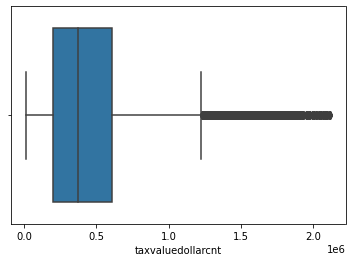

In [8]:
#Box and whisker for tax value dollar count
sns.boxplot(train.taxvaluedollarcnt)

<AxesSubplot:xlabel='calculatedfinishedsquarefeet'>

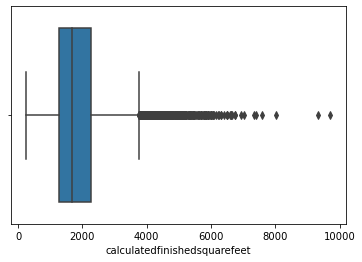

In [9]:
sns.boxplot(train.calculatedfinishedsquarefeet)

In [10]:
#Scale the data

#Create the object
scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.

scaler.fit(train)

train_scaled = scaler.transform(train)
validate_scaled = scaler.transform(validate)
test_scaled = scaler.transform(test)

In [11]:
# turn the numpy arrays into dataframes
train_scaled = pd.DataFrame(train_scaled, columns=train.columns)
validate_scaled = pd.DataFrame(validate_scaled, columns=train.columns)
test_scaled = pd.DataFrame(test_scaled, columns=train.columns)

In [ ]:
train_scaled.head()

In [ ]:
train_scaled.describe()

Text(0.5, 1.0, 'Scaled')

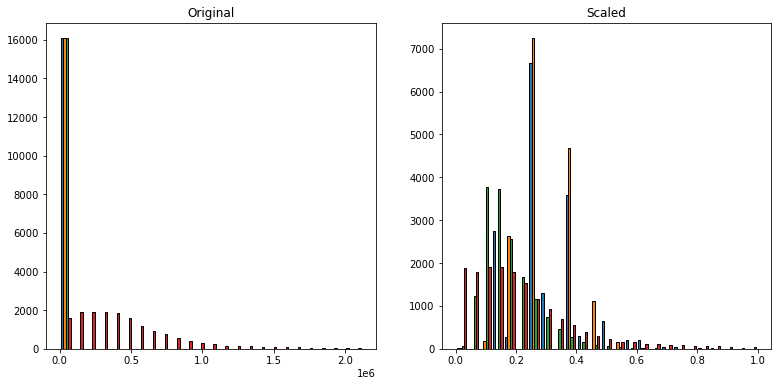

In [12]:
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(train_scaled, bins=25, ec='black')
plt.title('Scaled')

In [ ]:
train_scaled.bathroomcnt.hist()

In [ ]:
train_scaled.bedroomcnt.hist()

In [ ]:
train_scaled.calculatedfinishedsquarefeet.hist()

In [ ]:
train_scaled.taxvaluedollarcnt.hist()

## Initial Observations:
    - Bathrooms are right skewed
    - Bedrooms are close to normally distributed 
    - Squarefeet and Tax value are very skewed...likely have some outliers that will want to be explored in second iteration 
    - Square feet may be the most important feature for predicting a property's value

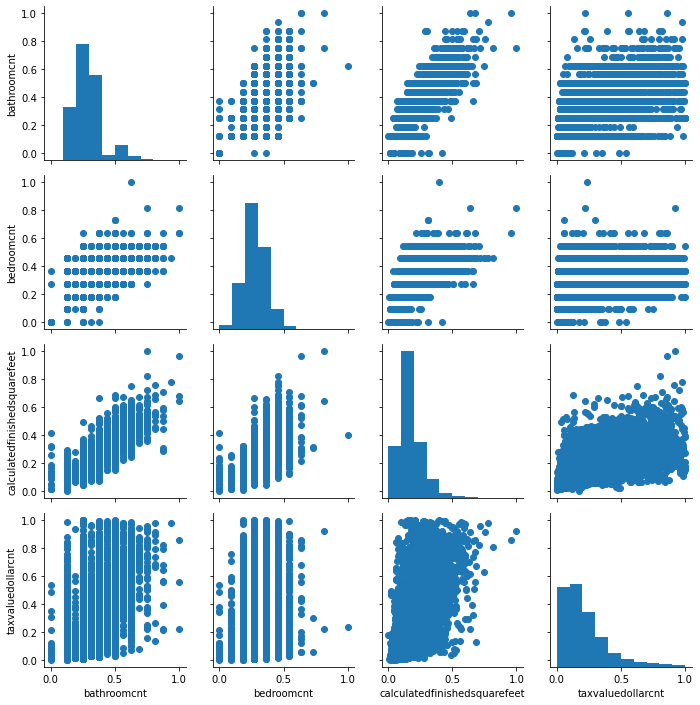

In [13]:
g = sns.PairGrid(train_scaled)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

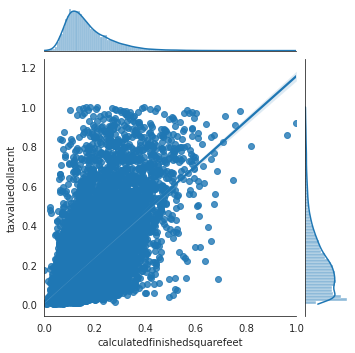

In [14]:
with sns.axes_style('white'):
    j = sns.jointplot("calculatedfinishedsquarefeet", "taxvaluedollarcnt", data=train_scaled, kind='reg', height=5);
plt.show()

(0.0, 4.0)

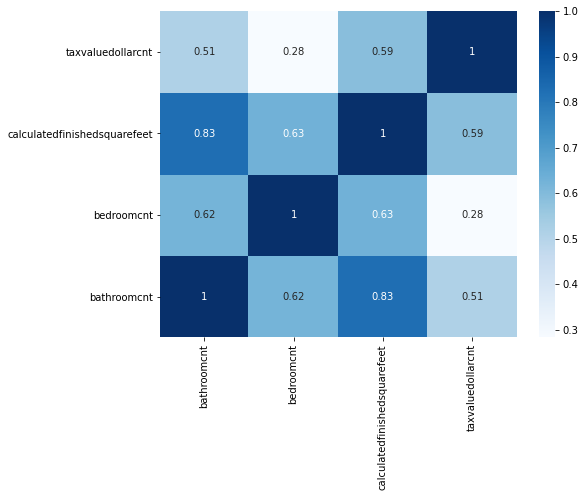

In [15]:
plt.figure(figsize=(8,6))
sns.heatmap(train_scaled.corr(), cmap='Blues', annot=True)
plt.ylim(0, 4)

## Takeaways after some visualizations:
- Expected upward trend in relationship between # of bedrooms and # of bathrooms
- Bedrooms and Bathrooms appear to correlate 
- Seems to be an outlier pulling down the slope of the regression line when comparing calculatedfinishedsquarefeet and taxvaluedollarcnt
- Squarefeet and bathrooms seems more closely related than squarefeet and bedrooms
    - This seems to make sense from my own experience. Some "bedrooms" can be very small. Bathrooms are more difficult to cut out squarefeet on. 


## Statistical Testing to run:
- Is there a correlation between squarefeet and tax value
- Bedrooms and Bathrooms seem to be tightly correlated. Test this.
    - Test to see if one is a better feature of value than the other. Do I need both?
    

### Correlation Test for Square Feet and Tax Value

H<sub>o</sub> = There is no linear correlation between a single unit property's value and the number of finished square feet. 

H<sub>*a*</sub> = There is a correlation between a property's value and square feet.

In [16]:
#Set confidence interval and alpha for Pearson's Correlation Test
confidence_int = .95
a = 1 - confidence_int

In [17]:
corr, p = stats.pearsonr(train_scaled.calculatedfinishedsquarefeet, train_scaled.taxvaluedollarcnt)
print(f"Pearson's correlation coefficient is: {corr} and the p-value is: {p}")

if p < a:
    print("Reject the null hypothesis.")
    print("Move forward with the understanding that there is a correlation between square feet and  tax value.")
else:
    print("Fail to reject the null hypothesis. Proceed with an understanding that there is no linear correlation.")

Pearson's correlation coefficient is: 0.5911913783373772 and the p-value is: 0.0
Reject the null hypothesis.
Move forward with the understanding that there is a correlation between square feet and  tax value.


#### Takeaways:
    - There is a correlation of .43 and while not the strongest correlation coefficient, finishedsquarefeet will be a feature that I utililze going forward with into modeling. 

### Correlation Test for Bedrooms and Bathrooms

H<sub>o</sub> = There is no linear correlation between the number of bathrooms and the number of bedrooms for a single unit property. 

H<sub>*a*</sub> = There is a correlation between the number of batrhooms and the number of bedrooms.

In [18]:
#Set confidence interval and alpha for Pearson's Correlation Test
confidence_int = .95
a = 1 - confidence_int

In [19]:
corr, p = stats.pearsonr(train_scaled.bathroomcnt, train_scaled.bedroomcnt)
print(f"Pearson's correlation coefficient is: {corr} and the p-value is: {p}")

if p < a:
    print("Reject the null hypothesis.")
    print("Move forward with the understanding that there is a correlation between bathroom and bedroom counts.")
else:
    print("Fail to reject the null hypothesis. Proceed with an understanding that there is no linear correlation.")

Pearson's correlation coefficient is: 0.6243936661708309 and the p-value is: 0.0
Reject the null hypothesis.
Move forward with the understanding that there is a correlation between bathroom and bedroom counts.


#### Takeaways:
    - A modest correlation between the bathroom and bedroom features exists.
    - Test to see if one feature is more correlated with taxvaluedollarcnt than the other.

### Correlation Test for Bedrooms and Value

H<sub>o</sub> = There is no linear correlation between the number of bedrooms for a single unit property and the property's value. 

H<sub>*a*</sub> = There is a correlation between the number of bedrooms and a property's value.

In [20]:
#Set confidence interval and alpha for Pearson's Correlation Test
confidence_int = .95
a = 1 - confidence_int

In [21]:
corr, p = stats.pearsonr(train_scaled.bedroomcnt, train_scaled.taxvaluedollarcnt)
print(f"Pearson's correlation coefficient is: {corr} and the p-value is: {p}")

if p < a:
    print("Reject the null hypothesis.")
    print("Move forward with the understanding that there is a correlation between bedroom count and property value.")
else:
    print("Fail to reject the null hypothesis. Proceed with an understanding that there is no linear correlation.")

Pearson's correlation coefficient is: 0.2835911742445363 and the p-value is: 4.606511577008421e-295
Reject the null hypothesis.
Move forward with the understanding that there is a correlation between bedroom count and property value.


#### Takeaways:
    - Weaker correlation coefficient for bedroom count and property value than the correlation for square feet and property value. 
    - Still, bedroom count is a feature that I will proceed with as a driver for property value going into modeling.

### Correlation Test for Bathrooms and Value

H<sub>o</sub> = There is no linear correlation between the number of bathrooms for a single unit property and the property's value. 

H<sub>*a*</sub> = There is a correlation between the number of bathrooms and a property's value.

In [22]:
#Set confidence interval and alpha for Pearson's Correlation Test
confidence_int = .95
a = 1 - confidence_int

corr, p = stats.pearsonr(train_scaled.bathroomcnt, train_scaled.taxvaluedollarcnt)
print(f"Pearson's correlation coefficient is: {corr} and the p-value is: {p}")

if p < a:
    print("Reject the null hypothesis.")
    print("Move forward with the understanding that there is a correlation between bathroom count and property value.")
else:
    print("Fail to reject the null hypothesis. Proceed with an understanding that there is no linear correlation.")


Pearson's correlation coefficient is: 0.5131566997451371 and the p-value is: 0.0
Reject the null hypothesis.
Move forward with the understanding that there is a correlation between bathroom count and property value.


#### Takeaways:
    - The number of bathrooms is more correlated with a property's value than bedrooms.
        - This is aligned with one of my initial hypotheses...
            - Could be due to the fact that there is greater variance in bedroom square footage than bathroom square footage? If I had that data, that might be interesting to look at...
    - Proceed with bathrooms as a feature for predicting a property's tax value

## Modeling

In [23]:
# Create X & y version of train, where y is a series with just the target variable and X are all the features. 
X_train = train_scaled.drop(columns=['taxvaluedollarcnt'])
y_train = train.taxvaluedollarcnt

X_validate = validate_scaled.drop(columns=['taxvaluedollarcnt'])
y_validate = validate.taxvaluedollarcnt

X_test = test_scaled.drop(columns=['taxvaluedollarcnt'])
y_test = test.taxvaluedollarcnt

### Baseline Model

In [24]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)
X_test = pd.DataFrame(X_test)

# 1. Predict taxvaluedollarcnt_pred_mean
taxvaluedollarcnt_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['taxvaluedollarcnt_pred_mean'] = taxvaluedollarcnt_pred_mean
y_validate['taxvaluedollarcnt_pred_mean'] = taxvaluedollarcnt_pred_mean
y_test['taxvaluedollarcnt_pred_mean'] = taxvaluedollarcnt_pred_mean

# 2. compute taxvaluedollarcnt_pred_median
taxvaluedollarcnt_pred_median = y_train['taxvaluedollarcnt'].median()
y_train['taxvaluedollarcnt_pred_median'] = taxvaluedollarcnt_pred_median
y_validate['taxvaluedollarcnt_pred_median'] = taxvaluedollarcnt_pred_median
y_test['taxvaluedollarcnt_pred_median'] = taxvaluedollarcnt_pred_median

In [25]:
#Evaluate the baseline model using the mean
evaluate.baseline_mean_errors(y_train.taxvaluedollarcnt)

{'sse': 2162962673269437.0,
 'mse': 134529336563.5923,
 'rmse': 366782.41037922236}

In [26]:
#Evaluate the baseline model using the median
evaluate.baseline_median_errors(y_train.taxvaluedollarcnt)

{'sse': 2279380767559911.5, 'mse': 141770168401.537, 'rmse': 376523.7952660323}

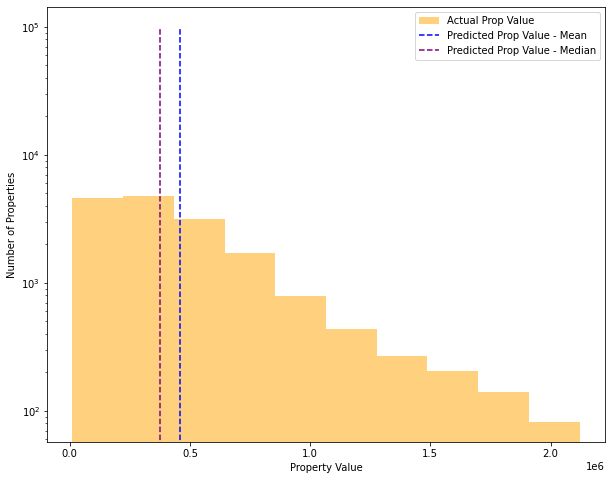

In [27]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(10, 8))
plt.hist(y_train.taxvaluedollarcnt, color='orange', alpha=.5, label="Actual Prop Value", log=True)
plt.vlines(y_train.taxvaluedollarcnt.mean(), 0, 10**5,  ls='--', color='blue', label="Predicted Prop Value - Mean")
plt.vlines(y_train.taxvaluedollarcnt.median(), 0, 10**5,  ls='--', color='purple', label="Predicted Prop Value - Median")
plt.xlabel("Property Value")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()

In [28]:
evaluate.baseline_mean_errors(y_train.taxvaluedollarcnt)

{'sse': 2162962673269437.0,
 'mse': 134529336563.5923,
 'rmse': 366782.41037922236}

In [29]:
#Now that I have established the mean as the baseline, I will drop the median and rename baseline to yhat_baseline
y_train.drop(columns={'taxvaluedollarcnt_pred_median'}, inplace=True)
y_validate.drop(columns={'taxvaluedollarcnt_pred_median'}, inplace=True)
y_test.drop(columns={'taxvaluedollarcnt_pred_median'}, inplace=True)
y_train.head()

,taxvaluedollarcnt,taxvaluedollarcnt_pred_mean
parcelid,,
11286725,113216.000,458535.577
11970357,518089.000,458535.577
17265846,424469.000,458535.577
17140998,72758.000,458535.577
12849027,872126.000,458535.577


In [30]:
y_train.rename(columns={'taxvaluedollarcnt_pred_mean': 'yhat_baseline'}, inplace=True)
y_validate.rename(columns={'taxvaluedollarcnt_pred_mean': 'yhat_baseline'}, inplace=True)
y_test.rename(columns={'taxvaluedollarcnt_pred_mean': 'yhat_baseline'}, inplace=True)
y_train.head()

,taxvaluedollarcnt,yhat_baseline
parcelid,,
11286725,113216.000,458535.577
11970357,518089.000,458535.577
17265846,424469.000,458535.577
17140998,72758.000,458535.577
12849027,872126.000,458535.577


<div class="alert alert-block alert-info"><b>Baseline Model Selection:</b> The baseline mean performs slightly better, that will be the baseline model.</div>

### LinearRegression (OLS) Model

In [31]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['yhat_lm'] = lm.predict(X_train)

# compute residuals
y_train['residual'] = y_train['yhat_lm'] - y_train['taxvaluedollarcnt']
y_train['baseline_residual'] = y_train['yhat_baseline'] - y_train['taxvaluedollarcnt']

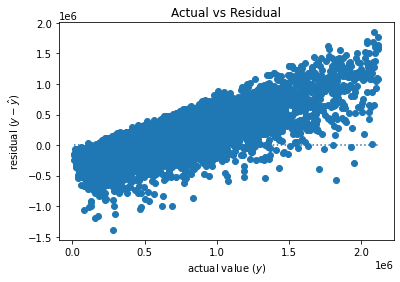

In [32]:
#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.taxvaluedollarcnt, y_train.yhat_lm)

In [33]:
#Retrieve evaluation metrics for Linear Regression Model on in-sample data
evaluate.regression_errors(y_train.taxvaluedollarcnt, y_train.yhat_lm)

sse    1367434263295394.000
ess     795528409974043.250
tss    2162962673269437.000
mse         85050022595.808
rmse             291633.370
r^2                   0.368
dtype: float64

In [34]:
#Does this model perform better than the baseline model on in-sample data?
evaluate.better_than_baseline(y_train.taxvaluedollarcnt, y_train.yhat_lm)

True

In [35]:
#How does this model perform on out of sample data?

# predict train
y_validate['yhat_lm'] = lm.predict(X_validate)

# compute residuals
y_validate['residual'] = y_validate['yhat_lm'] - y_validate['taxvaluedollarcnt']
y_validate['baseline_residual'] = y_validate['yhat_baseline'] - y_validate['taxvaluedollarcnt']

#Retrieve evaluation metrics
evaluate.regression_errors(y_validate.taxvaluedollarcnt, y_validate.yhat_lm)

sse    572844575325243.750
ess    336472211663776.438
tss    915852544677487.750
mse        83129382575.133
rmse            288321.665
r^2                  0.367
dtype: float64

In [36]:
#Does this model perform better than the baseline model on out of sample data?
evaluate.better_than_baseline(y_validate.taxvaluedollarcnt, y_validate.yhat_lm)

True

### Lasso Lars Model

In [37]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['yhat_lars'] = lars.predict(X_train)

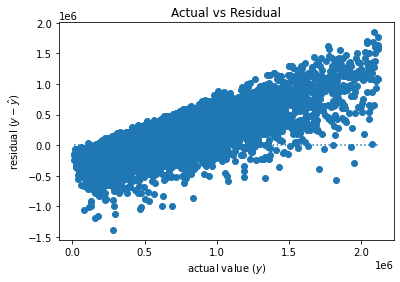

In [38]:
#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.taxvaluedollarcnt, y_train.yhat_lars)

In [39]:
#Retrieve evaluation metrics for Lasso + Lars Model on in-sample data
evaluate.regression_errors(y_train.taxvaluedollarcnt, y_train.yhat_lars)

sse    1367435838322428.000
ess     794196838406500.625
tss    2162962673269437.000
mse         85050120557.434
rmse             291633.538
r^2                   0.367
dtype: float64

In [40]:
#Does Lassor + Lars perform better than baseline on in-sample data?
evaluate.better_than_baseline(y_train.taxvaluedollarcnt, y_train.yhat_lars)

True

In [41]:
#How does the model perform on out of sample data?

# predict on validate
y_validate['yhat_lars'] = lars.predict(X_validate)

#Retrieve evaluation metrics for Lasso + Lars Model on out of sample data
evaluate.regression_errors(y_validate.taxvaluedollarcnt, y_validate.yhat_lars)

sse    572845585852085.750
ess    335908018197158.375
tss    915852544677487.750
mse        83129529219.574
rmse            288321.919
r^2                  0.367
dtype: float64

In [ ]:
rs = 143431773982830.312/500857407139901.875
print(f"{rs:.2%} of the variance in tax value can be explained by the features bedroomcnt, bathroomcnt, and finishedsquarefeet")

In [42]:
#Does Lassor + Lars perform better than baseline on in-sample data?
evaluate.better_than_baseline(y_validate.taxvaluedollarcnt, y_validate.yhat_lars)

True

### TweedieRegressor (GLM) Model

In [43]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['yhat_glm'] = glm.predict(X_train)

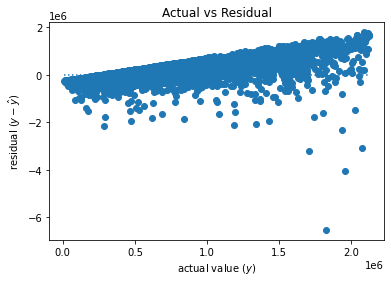

In [44]:
#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.taxvaluedollarcnt, y_train.yhat_glm)

In [45]:
#How does the GLM model perform on in-sample data?
evaluate.regression_errors(y_train.taxvaluedollarcnt, y_train.yhat_glm)

sse    1537961996827938.500
ess     962962640247880.625
tss    2162962673269437.000
mse         95656300337.600
rmse             309283.527
r^2                   0.445
dtype: float64

In [ ]:
rs = 357771400307920.125/1148759585740400.500
print(f"{rs:.2%} of the variance in tax value can be explained by the features bedroomcnt, bathroomcnt, and finishedsquarefeet")

In [46]:
#Does the GLM model perform better than baseline on in-sample data?
evaluate.better_than_baseline(y_train.taxvaluedollarcnt, y_train.yhat_glm)

True

In [47]:
# predict validate
y_validate['yhat_glm'] = glm.predict(X_validate)

In [48]:
#How does the GLM model perform on out of sample data?
evaluate.regression_errors(y_validate.taxvaluedollarcnt, y_validate.yhat_glm)

sse    707929802165155.500
ess    482686854570629.875
tss    915852544677487.750
mse       102732520993.347
rmse            320519.143
r^2                  0.527
dtype: float64

In [49]:
#Does the GLM model perform better than baseline on out of sample data?
evaluate.better_than_baseline(y_validate.taxvaluedollarcnt, y_validate.yhat_glm)

True

---

### USE GLM MODEL TO PREDICT ON TEST

In [ ]:
X_test.shape

In [50]:
# predict validate
y_test['yhat_glm'] = glm.predict(X_test)

In [51]:
# compute residuals
y_test['residual'] = y_test['yhat_glm'] - y_test['taxvaluedollarcnt']
y_test['baseline_residual'] = y_test['yhat_baseline'] - y_test['taxvaluedollarcnt']

In [52]:
#How does the GLM model perform on out of sample data?
evaluate.regression_errors(y_test.taxvaluedollarcnt, y_test.yhat_glm)

sse    574048496467835.750
ess    427500652866860.062
tss    767748422651947.250
mse        99956206941.988
rmse            316158.516
r^2                  0.557
dtype: float64

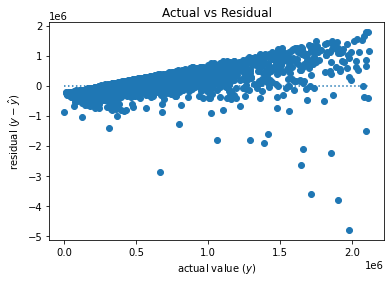

<AxesSubplot:xlabel='taxvaluedollarcnt', ylabel='yhat_glm'>

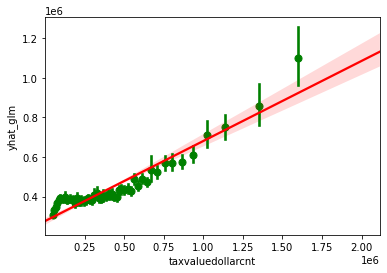

In [58]:
#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_test.taxvaluedollarcnt, y_test.yhat_glm)
sns.regplot(x = 'taxvaluedollarcnt', y = 'yhat_glm', data = y_test,x_bins=50, fit_reg=True, color='green', line_kws={"color":"red"})

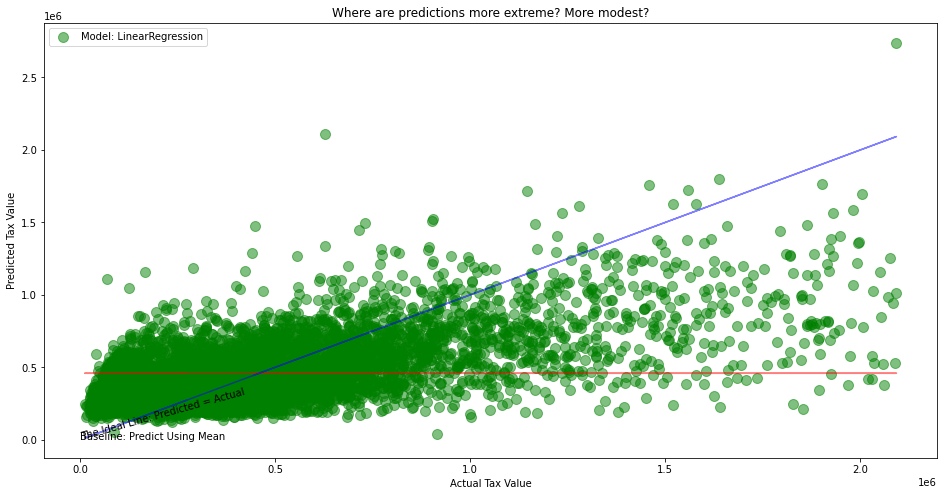

In [53]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.yhat_baseline, alpha=.5, color="red", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.taxvaluedollarcnt, y_validate.yhat_lm, 
            alpha=.5, color='green', s=100, label="Model: LinearRegression")

plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

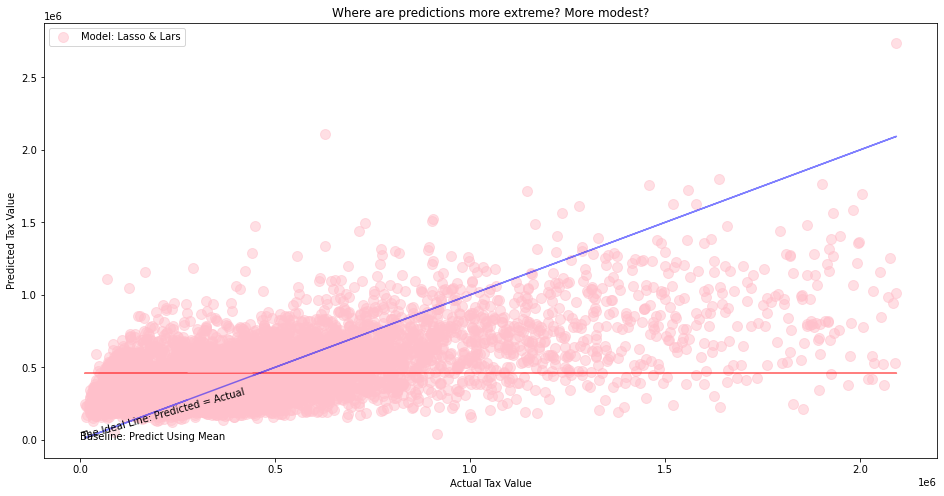

In [54]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.yhat_baseline, alpha=.5, color="red", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.taxvaluedollarcnt, y_validate.yhat_lars, 
            alpha=.5, color="pink", s=100, label="Model: Lasso & Lars")

plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

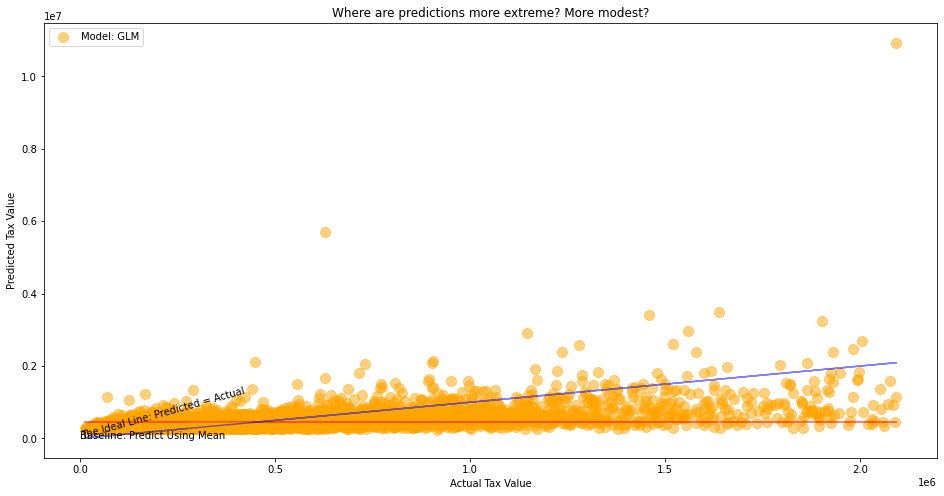

In [55]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.yhat_baseline, alpha=.5, color="red", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.taxvaluedollarcnt, y_validate.yhat_glm, 
            alpha=.5, color="orange", s=100, label="Model: GLM")

plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

#### Takeaways:
    - Tweedie Regressor Model did not beat baseline on unscaled data. It DID beat baseline on scaled data.
    - Tweedie Regressor Model can explain more of the variance than other models.
    - LM model has the lowest of the RMSE scores, but does not have as high as the GLM r^2
    
    - The above is true from the modeling done with scaled data and using 3 when calculating the upper and lower bounds for outliers.
    - Removing outliers for calculatedsquarefeet made my models less accurate. So I am not touching outliers for sq.feet.
    
    - How do the models perform when I change how I handle outliers and drop to 1.5?
        - All models perform better when using 3 and expanding what outliers are included.
    

---